## Importing the libraries

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import RobustScaler
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import wandb


In [15]:
wandb.login()

True

In [16]:

df = pd.read_excel('/mnt/d/WSL/Flight-Fare-Prediction/Dataset/Data_Train.xlsx')
df.head()


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Understanding the dataset

#### Imformation of the dataset

In [17]:

df_info = df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


#### Shape of the dataset

In [18]:
rows, columns = df.shape

print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

Number of rows: 10683
Number of columns: 11


#### Finding NULL Values in the dataset

In [19]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

#### Finding the column which has NaN Values
Since the number of null values or missing values are negligible so am removing it

In [20]:
df[df['Route'].isnull() | df['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


#### Removing the NaN Values

In [21]:
df.dropna(inplace = True)

In [22]:
df.shape

(10682, 11)

#### Plotting the datatypes

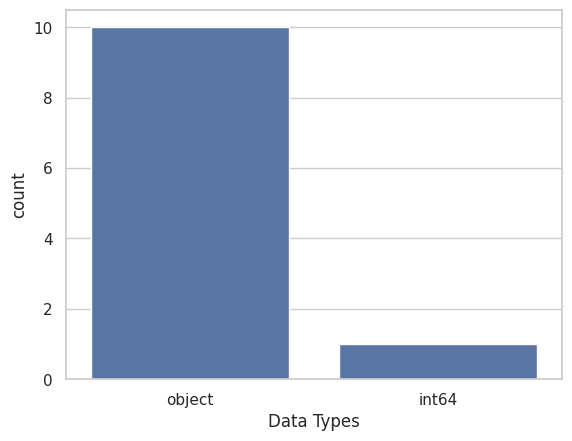

In [23]:
import plotly.express as px
dtypes_df = pd.DataFrame(df.dtypes, columns=['Data Types'])

# Create a count plot using Seaborn
sns.set_theme(style="whitegrid")
ax = sns.countplot(x='Data Types', data=dtypes_df)
plt.show()



### Interpretaton:
- Different types of Data types

#### Statistical Interpretation

In [24]:
df.describe()


,Price
count,10682.000000
mean,9087.214567
std,4611.548810
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


#### Checking for duplicate rows and removing it

In [25]:
df.duplicated().sum()

220

In [26]:
df.drop_duplicates(inplace=True)

## Feature Engineering

#### Duration column

In [27]:
def convert_duration(Duration):
        if len(Duration.split()) == 2:          # the length of duration in 2, 9h 30m e.g
            # taking the hour value
            hours = int(Duration.split()[0][: -1])      # 0 means the part before the space and -1 to discard the character,  
            # taking the minutes value
            minutes = int(Duration.split()[1][: -1])    # 0 means the part before the space and -1 to discard the character, 
           # converting to minutes
            return hours * 60 + minutes
        else:
            # if just hour is present
            return int(Duration[: -1]) * 60
df['Duration'] = df['Duration'].apply(convert_duration)
df.rename(columns={'Duration': 'Duration (in mins)'}, inplace=True)

In [28]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration (in mins),Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2 stops,No info,7662


#### Airlines

In [29]:
df['Airline'] =df['Airline'].str.replace("Vistara Premium economy", "Vistara")
df['Airline'] =df['Airline'].str.replace("Jet Airways Business", "Jet Airways")
df['Airline'] =df['Airline'].str.replace("Multiple carriers Premium economy", "Multiple carriers")
df.drop(df[df['Airline'] == 'Trujet'].index, inplace=True)


#### Date of Journey

In [30]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
df['Day_of_Week'] = pd.to_datetime(df['Date_of_Journey']).dt.day_name()


In [31]:
# adding a feature as weekend
df['Weekend'] = df['Day_of_Week'].isin(['Saturday', 'Sunday']).astype(int)

Constant features don't contribute meaningful information to the model, and including them in the prediction process might not be helpful. 
'year' column having the same value (2019) in every row, it doesn't provide any variation in the data,

In [32]:
# Extracting the days, months and years from the Date_of_Journey column
df['Day'] = df['Date_of_Journey'].dt.day
df['month'] = df['Date_of_Journey'].dt.month

df.drop('Date_of_Journey',axis = 1, inplace = True)     #dropping the column 
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration (in mins),Total_Stops,Additional_Info,Price,Day_of_Week,Weekend,Day,month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,non-stop,No info,3897,Sunday,1,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2 stops,No info,7662,Wednesday,0,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2 stops,No info,13882,Sunday,1,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1 stop,No info,6218,Sunday,1,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,285,1 stop,No info,13302,Friday,0,1,3


#### Total stops

In [33]:
df['Total_Stops'] = df['Total_Stops'].str.extract('(\d+)').astype(float)
df.rename(columns={'Total_Stops': 'Total_Stops'}, inplace=True)
df['Total_Stops'].fillna(0, inplace=True)

/tmp/ipykernel_118827/57672341.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Total_Stops'].fillna(0, inplace=True)


In [34]:
df['Total_Stops'].value_counts()

Total_Stops
1.0    5624
0.0    3475
2.0    1318
3.0      43
4.0       1
Name: count, dtype: int64

#### Additional Information

In [35]:
df['Additional_Info'].value_counts()

Additional_Info
No info                         8181
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

In [36]:
# I figured that this column is not that useful because almost 8000 people didnt provide additional info
df.drop('Additional_Info',axis = 1, inplace = True)  

#### Departure time

In [37]:
df['Dep_Time'] = df['Dep_Time'].str.extract(r'(\d{2}:\d{2})')
df['Dep_Hours'] = df['Dep_Time'].str[:2].astype(int)        # Extract hours from the string and convert to input
df['Dep_Minutes'] = df['Dep_Time'].str[3:].astype(int)      # Extract mins from the string and convert to input

df.drop('Dep_Time',axis = 1, inplace = True)     #dropping the column 

#### Arrival Time

In [38]:
df['Arrival_Time'] = df['Arrival_Time'].str.extract(r'(\d{2}:\d{2})')
df['Arv_Hours'] = df['Arrival_Time'].str[:2].astype(int)        # Extract hours from the string and convert to input
df['Arv_Minutes'] = df['Arrival_Time'].str[3:].astype(int)      # Extract mins from the string and convert to input

df.drop('Arrival_Time',axis = 1, inplace = True)     #dropping the column 

In [39]:
df.sample(5)

,Airline,Source,Destination,Route,Duration (in mins),Total_Stops,Price,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes
3177,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,555,1.0,8401,Thursday,0,21,3,10,0,19,15
183,Jet Airways,Kolkata,Banglore,CCU → BOM → BLR,960,1.0,9663,Monday,0,6,5,20,0,12,0
4285,Jet Airways,Kolkata,Banglore,CCU → BOM → BLR,1155,1.0,8529,Wednesday,0,12,6,14,5,9,20
880,Jet Airways,Kolkata,Banglore,CCU → DEL → BLR,1450,1.0,12692,Thursday,0,6,6,9,35,9,45
4932,Jet Airways,Mumbai,Hyderabad,BOM → HYD,85,0.0,8040,Monday,0,1,4,7,5,8,30


#### Routes

In [40]:
# Group by 'Route' and calculate the average price for each route
route_stats = df.groupby('Route')['Price'].agg(['count', 'mean']).reset_index()

# Rename the columns for clarity
route_stats.columns = ['Route', 'Count', 'Average_Price']

sorted_route_stats = route_stats.sort_values(by=['Average_Price', 'Count'], ascending=False)
sorted_route_stats

,Route,Count,Average_Price
44,BOM → DED → DEL → HYD,1,24115.000000
51,BOM → JDH → DEL → HYD,3,23867.000000
57,BOM → VNS → DEL → HYD,1,23528.000000
56,BOM → UDR → DEL → HYD,1,22950.000000
38,BOM → BDQ → DEL → HYD,2,22792.500000
...,...,...,...
89,CCU → MAA → BLR,65,5240.876923
79,CCU → HYD → BLR,53,4910.018868
126,MAA → CCU,381,4789.892388
63,CCU → BLR,724,4556.055249


In [41]:
unique_values_count = df['Route'].value_counts()
print(unique_values_count)

Route
DEL → BOM → COK          2376
BLR → DEL                1536
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → RPR → HYD → BLR       1
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → BBI → HYD             1
Name: count, Length: 127, dtype: int64


In [42]:
df.drop('Route',axis = 1, inplace = True)  

#### Putting the price columns as our last because its the target

In [43]:
price_column = df.pop('Price')
df['Price'] = price_column

In [44]:
df.sample(5)

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes,Price
6585,Jet Airways,Kolkata,Banglore,345,1.0,Thursday,0,9,5,14,5,19,50,14781
9253,Multiple carriers,Delhi,Cochin,480,1.0,Thursday,0,21,3,7,30,15,30,11269
9137,Jet Airways,Banglore,New Delhi,710,1.0,Tuesday,0,12,3,22,55,10,45,11087
724,IndiGo,Delhi,Cochin,325,1.0,Wednesday,0,15,5,2,0,7,25,8618
510,Jet Airways,Banglore,New Delhi,325,1.0,Friday,0,1,3,7,0,12,25,26890


## Exploratory Data Analysis

#### Univariate

(A) Categorical Values

Text(0.5, 1.0, 'Month Distribution')

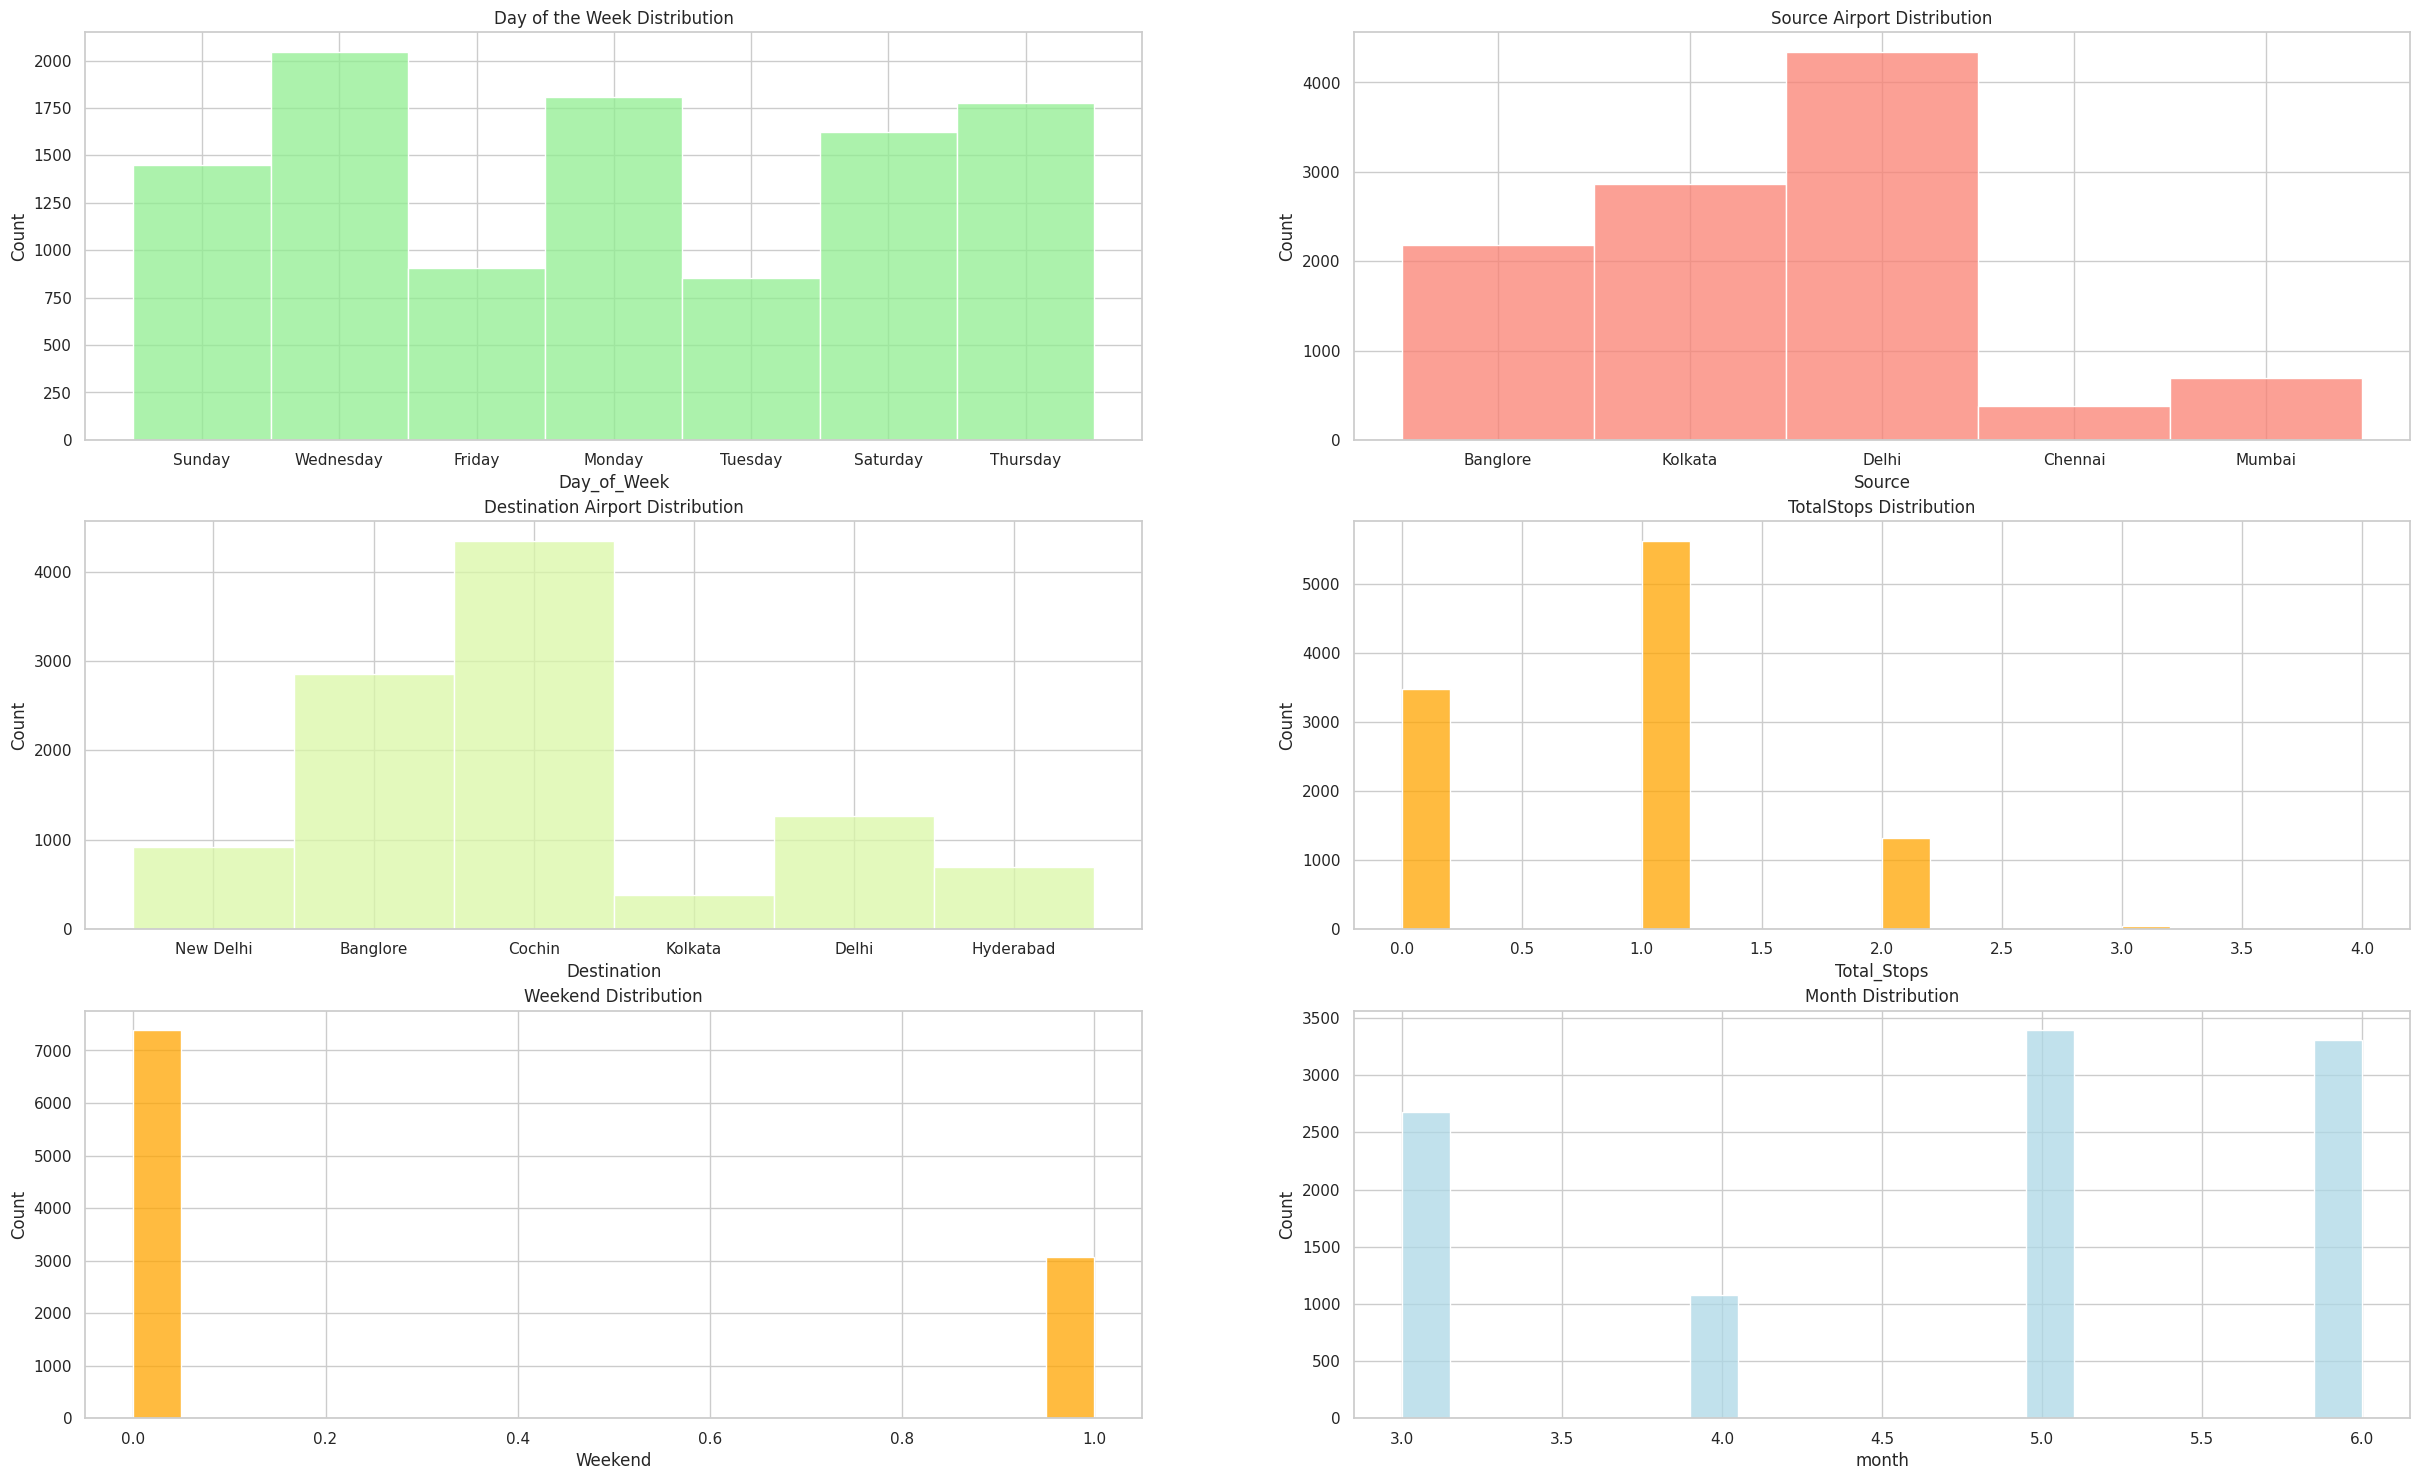

In [45]:
# Creating the subplots
fig, axes = plt.subplots(3, 2, figsize=(30, 18))  # 1 row, 3 columns

# Plotting each emotion

sns.histplot(df['Day_of_Week'], bins=20, kde=False, ax=axes[0,0], color='lightgreen')
axes[0,0].set_title('Day of the Week Distribution')

sns.histplot(df['Source'], bins=20, kde=False, ax=axes[0,1], color='salmon')
axes[0,1].set_title('Source Airport Distribution')

sns.histplot(df['Destination'], bins=20, kde=False, ax=axes[1,0], color='#DAF7A6')
axes[1,0].set_title('Destination Airport Distribution')

sns.histplot(df['Total_Stops'], bins=20, kde=False, ax=axes[1,1], color='orange')
axes[1,1].set_title('TotalStops Distribution')

sns.histplot(df['Weekend'], bins=20, kde=False, ax=axes[2,0], color='orange')
axes[2,0].set_title('Weekend Distribution')

sns.histplot(df['month'], bins=20, kde=False, ax=axes[2,1], color='lightblue')
axes[2,1].set_title('Month Distribution')

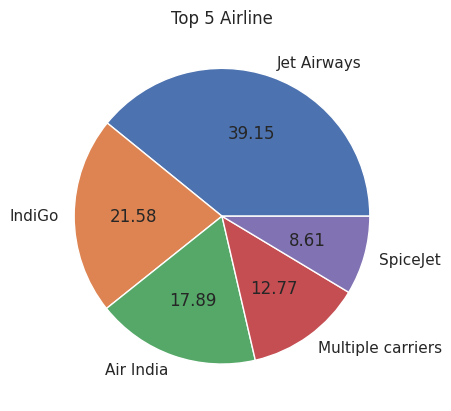

In [47]:
brand_counts = df['Airline'].value_counts()
top_5_brands = brand_counts.head(5)
df_top_5 = df[df['Airline'].isin(top_5_brands.index)]
plt.pie(top_5_brands, labels=top_5_brands.index, autopct='%.2f')
plt.title('Top 5 Airline')
plt.show()
     



In [48]:
df.sample(5)

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes,Price
2664,Multiple carriers,Delhi,Cochin,890,1.0,Wednesday,0,27,3,4,0,18,50,11299
6225,Vistara,Mumbai,Hyderabad,670,1.0,Wednesday,0,6,3,8,45,19,55,12395
7908,Jet Airways,Delhi,Cochin,540,1.0,Monday,0,24,6,10,0,19,0,10262
134,Multiple carriers,Delhi,Cochin,840,1.0,Tuesday,0,21,5,11,30,1,30,14067
1395,Air India,Kolkata,Banglore,1195,2.0,Sunday,1,9,6,12,0,7,55,10151


(B) Numeriacl Values

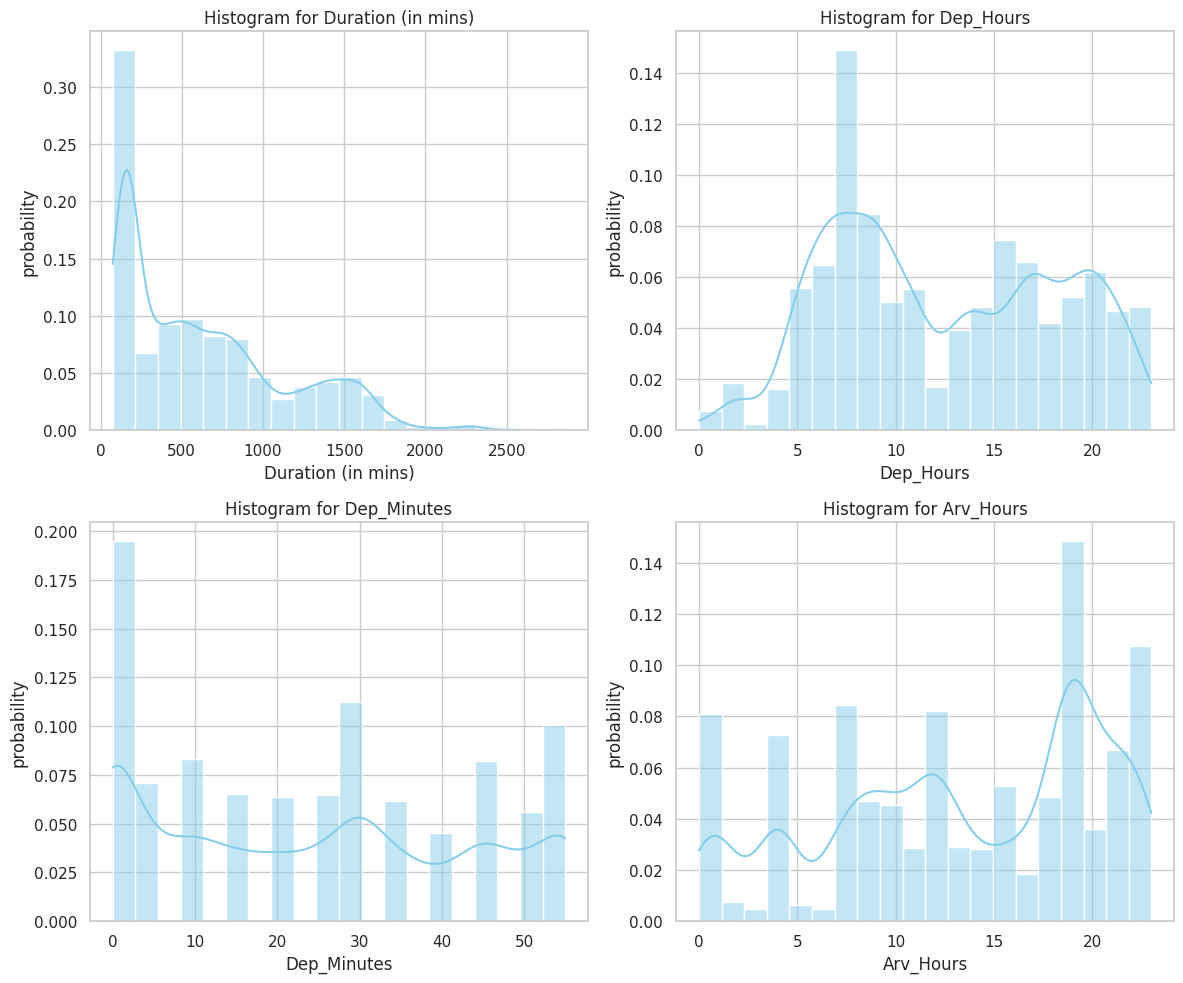

In [49]:
numeric_columns = ['Duration (in mins)','Dep_Hours', 'Dep_Minutes', 'Arv_Hours','Arv_Minutes','Price']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the 2D array of axes into a 1D array for easier iteration
axes = axes.flatten()

# Plot histograms for numeric columns
for i, column in enumerate(numeric_columns[:4]):  # Considering the first 4 numeric columns for a 2x2 grid
    sns.histplot(df[column], bins=20, kde=True, color='skyblue', ax=axes[i], stat = 'probability')
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('probability')

# Adjust layout
plt.tight_layout()
plt.show()

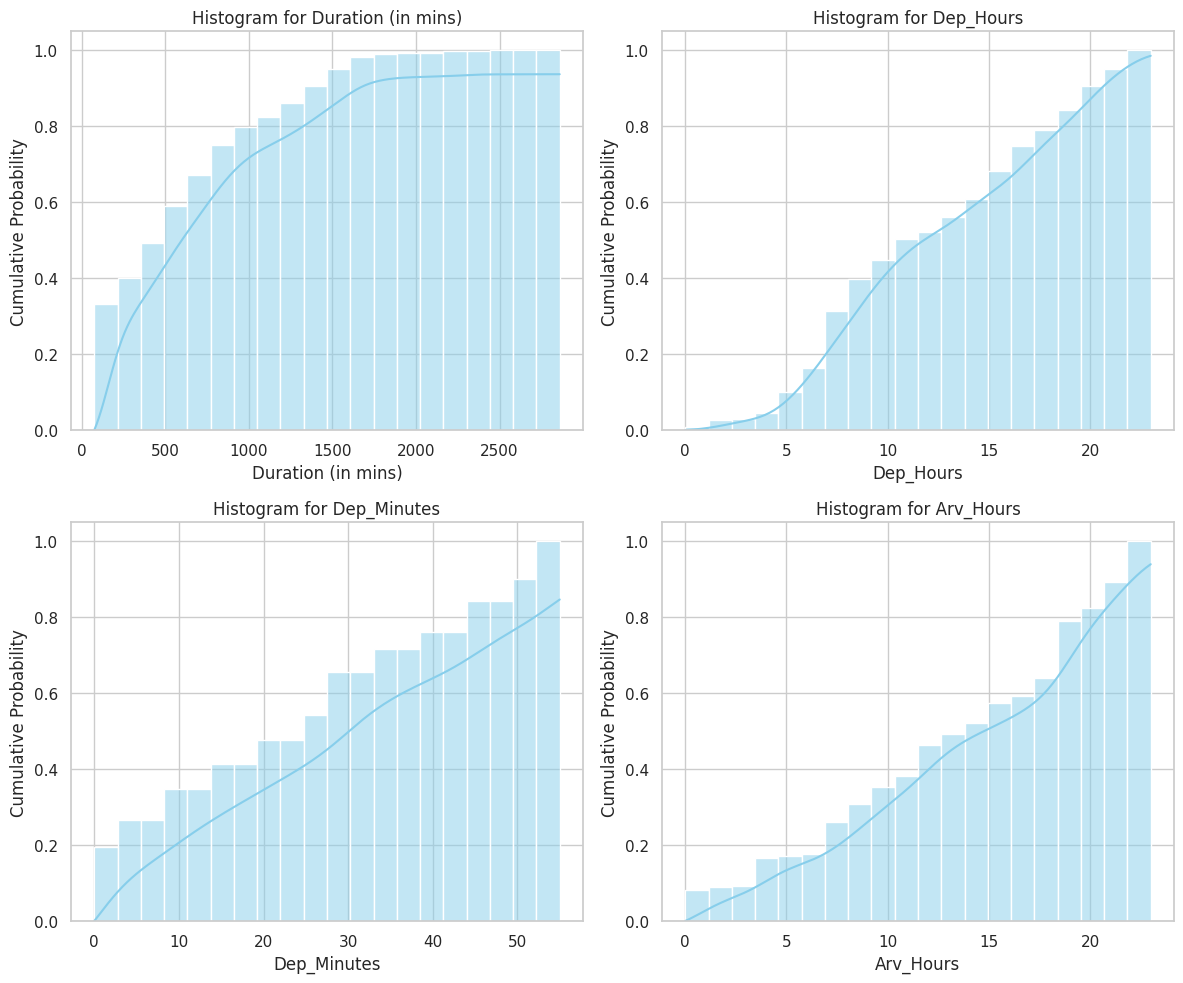

In [50]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the 2D array of axes into a 1D array for easier iteration
axes = axes.flatten()

# Plot histograms for numeric columns with cumulative distribution function
for i, column in enumerate(numeric_columns[:4]):  # Considering the first 4 numeric columns for a 2x2 grid
    sns.histplot(df[column], bins=20, kde=True, color='skyblue', ax=axes[i], stat='probability', cumulative=True)
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Cumulative Probability')

# Adjust layout
plt.tight_layout()
plt.show()


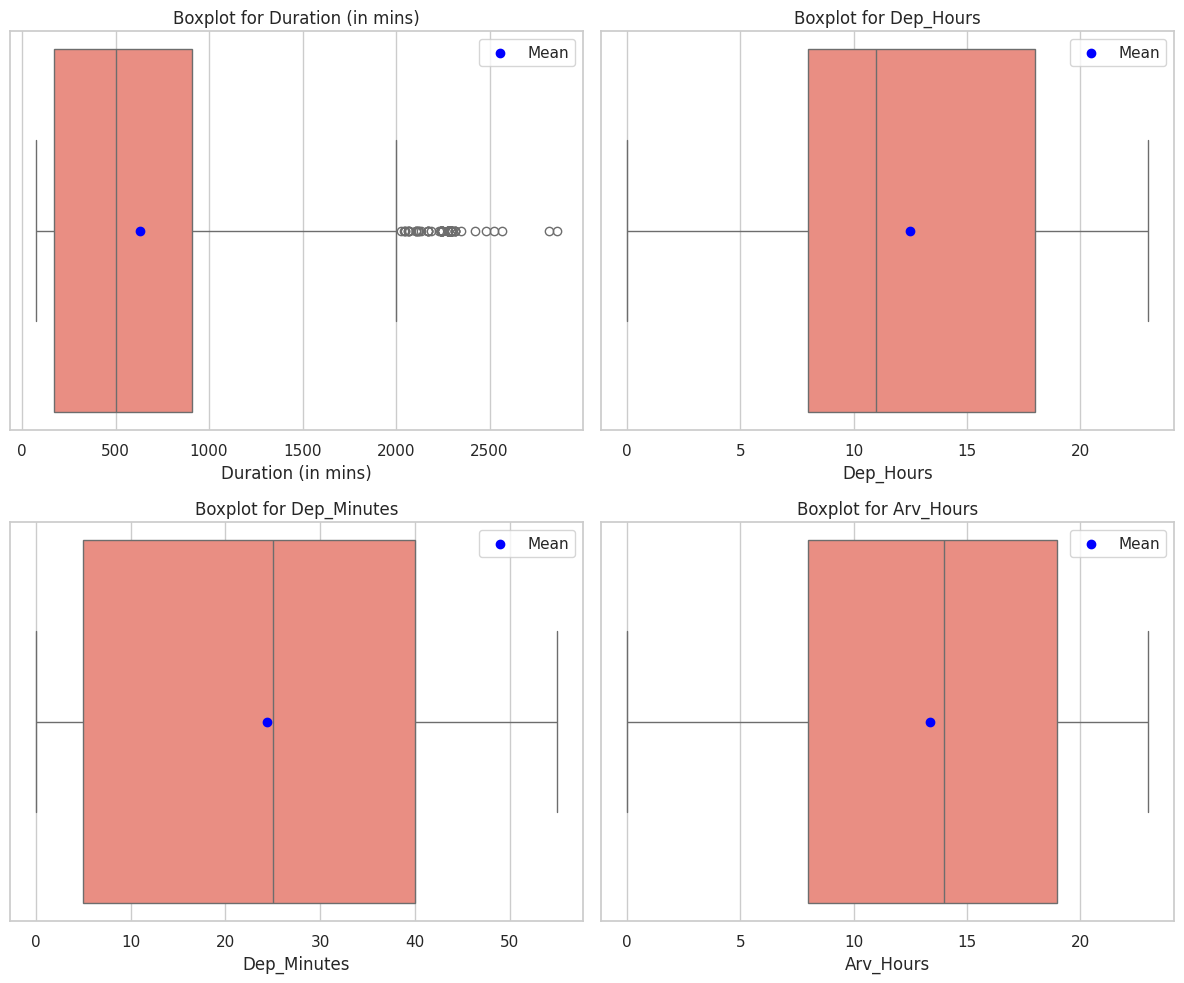

In [51]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the 2D array of axes into a 1D array for easier iteration
axes = axes.flatten()

# Iterate over numeric columns
for i, column in enumerate(numeric_columns[:4]):  # Considering the first 4 numeric columns for a 2x2 grid
    # Plot the boxplot
    sns.boxplot(x=df[column], color='salmon', ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')
    axes[i].set_xlabel(column)

    # Identify outliers using IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Handle outliers by clipping values to the lower and upper bounds
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    # Plot mean as a point
    mean_point = axes[i].scatter(df[column].mean(), 0, color='blue', marker='o', label='Mean', zorder=5)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


#### Bivariate 

In [52]:
df.sample()

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes,Price
2041,Jet Airways,Delhi,Cochin,1530,1.0,Thursday,0,9,5,17,30,19,0,12373


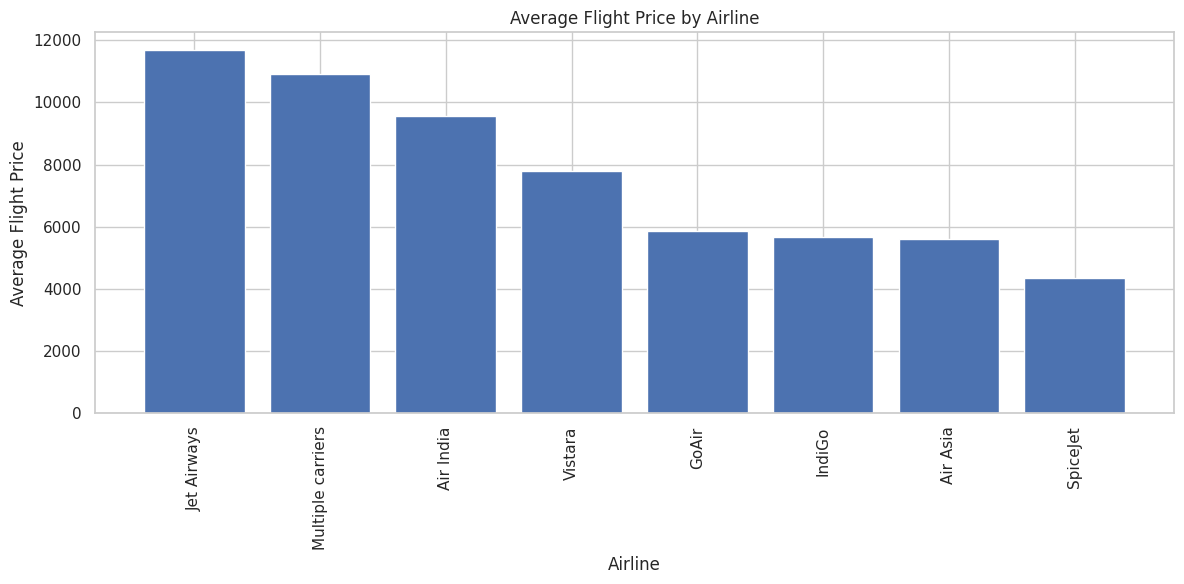

In [53]:
airline_prices = df.groupby('Airline')['Price'].mean().reset_index()        # grouping the mean price of each flight

# sorting the airlines by average price in decending order
airline_prices = airline_prices.sort_values(by="Price", ascending =False)

# Creating a bar chart
plt.figure(figsize=(12, 6))
plt.bar(airline_prices['Airline'], airline_prices['Price'])
plt.xlabel('Airline')
plt.ylabel('Average Flight Price')
plt.title('Average Flight Price by Airline')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

/tmp/ipykernel_118827/2426826048.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Weekend', 'Weekday'], y=[avg_price_weekend, avg_price_weekday], palette='pastel')


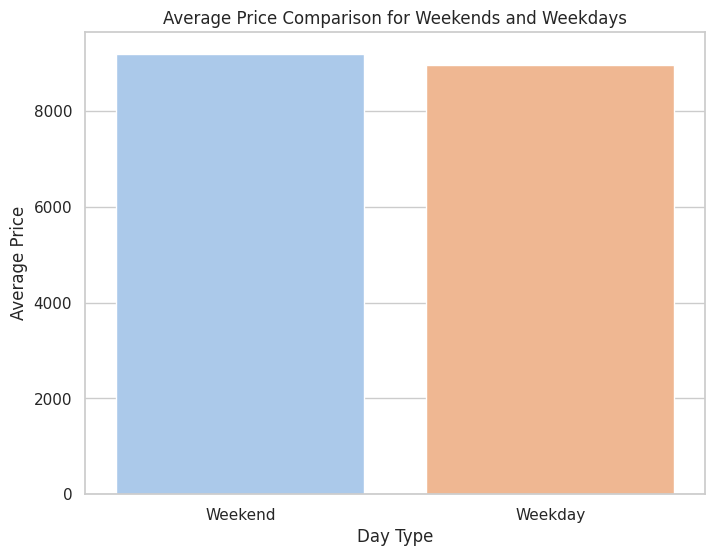

In [54]:
avg_price_weekend = df[df['Weekend'] == 1]['Price'].mean()
avg_price_weekday = df[df['Weekend'] == 0]['Price'].mean()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=['Weekend', 'Weekday'], y=[avg_price_weekend, avg_price_weekday], palette='pastel')
plt.title('Average Price Comparison for Weekends and Weekdays')
plt.xlabel('Day Type')
plt.ylabel('Average Price')
plt.show()

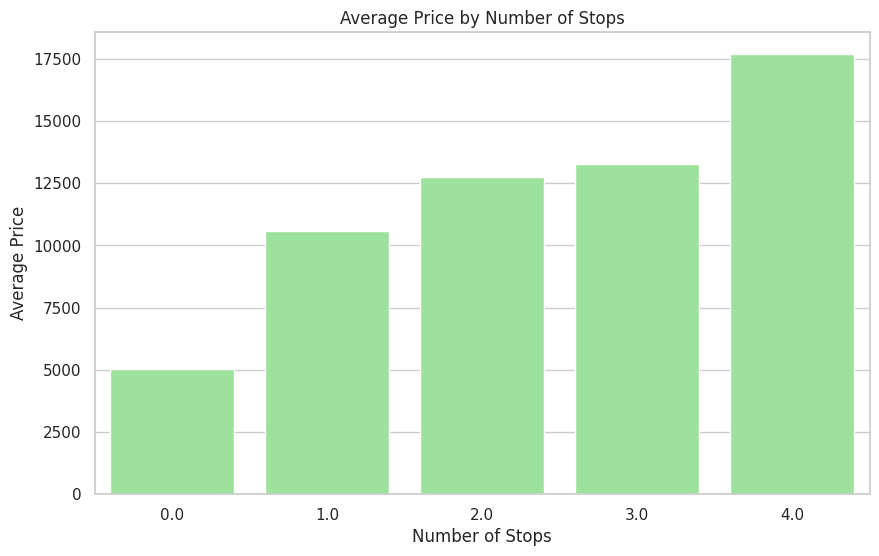

In [55]:
total_stops_by_prices = df.groupby('Total_Stops')['Price'].mean().reset_index()  

plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Stops', y='Price', data=total_stops_by_prices, color='lightgreen')
plt.title('Average Price by Number of Stops')
plt.xlabel('Number of Stops')
plt.ylabel('Average Price')
plt.show()

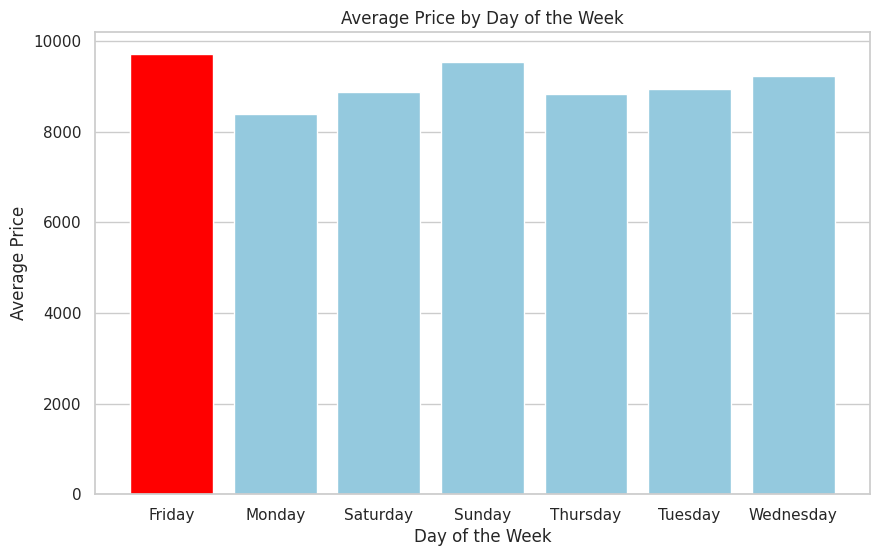

In [56]:
total_stops_by_prices = df.groupby('Day_of_Week')['Price'].mean().reset_index()

# Find the day with the highest average price
day_highest_avg_price = total_stops_by_prices.loc[total_stops_by_prices['Price'].idxmax(), 'Day_of_Week']

# Create a bar plot with the day with the highest average price in red
plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='Price', data=total_stops_by_prices, color='skyblue')
plt.title('Average Price by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price')

# Highlight the bar for the day with the highest average price in red
plt.bar(total_stops_by_prices[total_stops_by_prices['Day_of_Week'] == day_highest_avg_price].index,
        total_stops_by_prices[total_stops_by_prices['Day_of_Week'] == day_highest_avg_price]['Price'],
        color='red')

plt.show()


In [57]:
df.sample()

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes,Price
1324,Jet Airways,Banglore,Delhi,180,0.0,Wednesday,0,24,4,17,45,20,45,4544


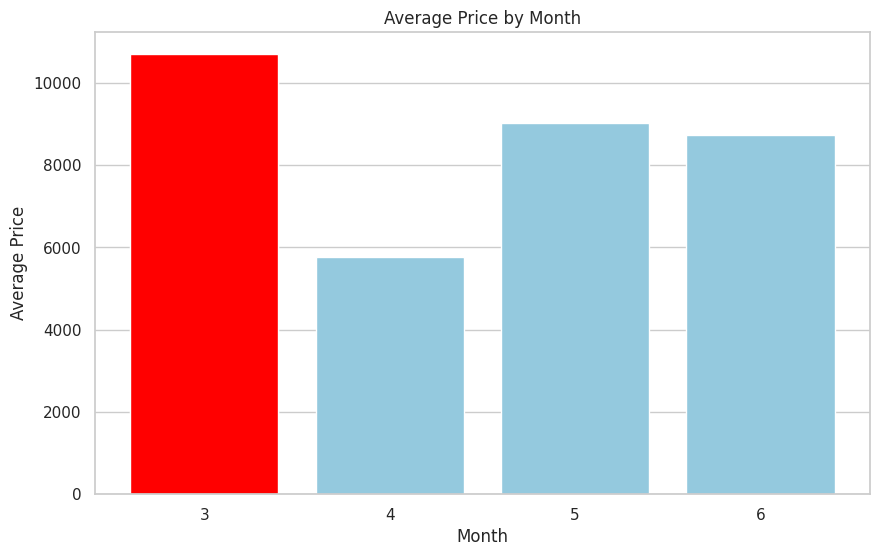

In [58]:
total_stops_by_prices = df.groupby('month')['Price'].mean().reset_index()

# Find the day with the highest average price
day_highest_avg_price = total_stops_by_prices.loc[total_stops_by_prices['Price'].idxmax(), 'month']

# Create a bar plot with the day with the highest average price in red
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='Price', data=total_stops_by_prices, color='skyblue')
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')

# Highlight the bar for the day with the highest average price in red
plt.bar(total_stops_by_prices[total_stops_by_prices['month'] == day_highest_avg_price].index,
        total_stops_by_prices[total_stops_by_prices['month'] == day_highest_avg_price]['Price'],
        color='red')

plt.show()


In [59]:


sorted_route_stats

,Route,Count,Average_Price
44,BOM → DED → DEL → HYD,1,24115.000000
51,BOM → JDH → DEL → HYD,3,23867.000000
57,BOM → VNS → DEL → HYD,1,23528.000000
56,BOM → UDR → DEL → HYD,1,22950.000000
38,BOM → BDQ → DEL → HYD,2,22792.500000
...,...,...,...
89,CCU → MAA → BLR,65,5240.876923
79,CCU → HYD → BLR,53,4910.018868
126,MAA → CCU,381,4789.892388
63,CCU → BLR,724,4556.055249


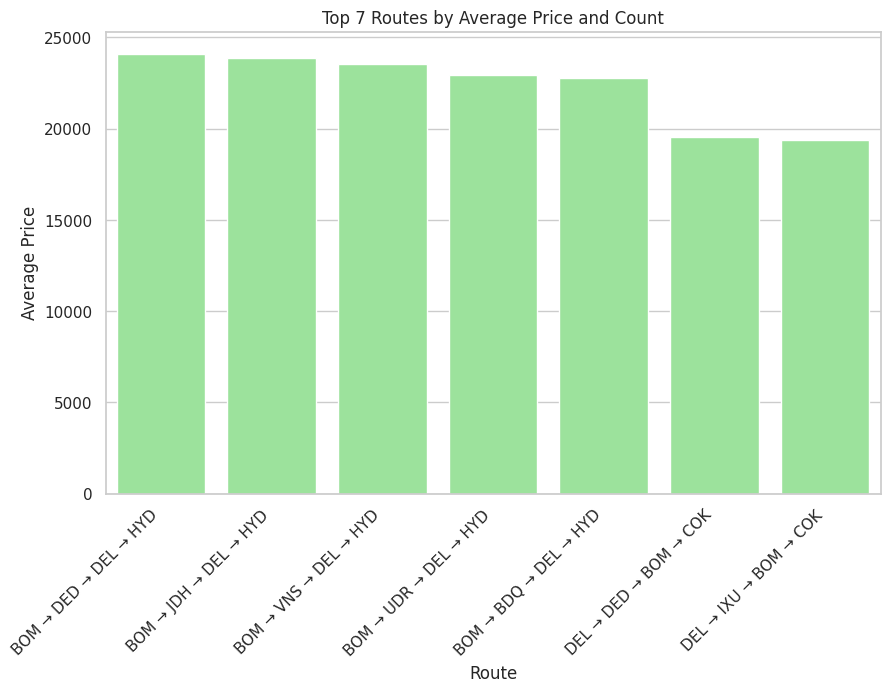

In [60]:
top_5_routes_count = sorted_route_stats.head(7)

# Select the top 5 routes based on average price
top_5_routes_price = sorted_route_stats.nlargest(7, 'Average_Price')

# Combine the top 5 routes based on both count and average price
top_5_routes = pd.merge(top_5_routes_count, top_5_routes_price, on='Route', suffixes=('_count', '_price'))

# Create a bar plot for the top 5 routes
plt.figure(figsize=(10, 6))
sns.barplot(x='Route', y='Average_Price_price', data=top_5_routes, color='lightgreen')
plt.title('Top 7 Routes by Average Price and Count')
plt.xlabel('Route')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


#### Multivariate

Correlation

In [61]:
# Assuming 'df' is your DataFrame
df_encoded = pd.get_dummies(df, columns=['Airline', 'Source', 'Destination', 'Day_of_Week'], drop_first=True)



correlation_matrix = df_encoded.corr()


price_correlations = correlation_matrix['Price'].sort_values(ascending=False)

# Display the variables strongly related to 'Term Deposit'
print("Variables strongly related to Price:")
print(price_correlations)

Variables strongly related to Price:
Price                        1.000000
Total_Stops                  0.602078
Duration (in mins)           0.504304
Airline_Jet Airways          0.424030
Destination_Cochin           0.261421
Source_Delhi                 0.261421
Destination_New Delhi        0.199391
Airline_Multiple carriers    0.147029
Airline_Air India            0.050315
Day_of_Week_Sunday           0.043812
Arv_Hours                    0.031064
Day_of_Week_Wednesday        0.022645
Weekend                      0.022067
Source_Kolkata               0.015363
Dep_Hours                    0.005164
Day_of_Week_Tuesday         -0.005240
Day_of_Week_Saturday        -0.014043
Day_of_Week_Thursday        -0.018823
Dep_Minutes                 -0.024262
Airline_Vistara             -0.057852
Day_of_Week_Monday          -0.061762
Arv_Minutes                 -0.086197
Airline_GoAir               -0.094112
month                       -0.113562
Day                         -0.159148
Source_Chenna

In [62]:
df.sample(5)

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes,Price
9816,Jet Airways,Delhi,Cochin,450,1.0,Saturday,1,15,6,11,30,19,0,14714
1584,Jet Airways,Delhi,Cochin,1425,1.0,Thursday,0,6,6,19,15,19,0,14714
4673,Air India,Delhi,Cochin,185,0.0,Friday,0,21,6,18,5,21,10,5411
9219,Air India,Delhi,Cochin,500,2.0,Wednesday,0,12,6,10,55,19,15,11753
8536,Jet Airways,Banglore,New Delhi,1165,1.0,Friday,0,1,3,14,5,9,30,25735


In [63]:
# Assuming you want to apply robust scaling to columns 5 to 10 and 20 to 25
columns_to_scale = list(range(3, 5)) + list(range(6, 13))

trf2 = ColumnTransformer([
    ('scale', RobustScaler(), columns_to_scale)
])

#### Measuring the categorical values

In [64]:
categorical_columns = df.select_dtypes(include=['object']).columns

# Loop through each categorical column and display unique value counts
for column in categorical_columns:
    unique_values_count = df[column].value_counts()
    print(f"Unique values count for {column}:\n{unique_values_count}\n")


Unique values count for Airline:
Airline
Jet Airways          3706
IndiGo               2043
Air India            1694
Multiple carriers    1209
SpiceJet              815
Vistara               481
Air Asia              319
GoAir                 194
Name: count, dtype: int64

Unique values count for Source:
Source
Delhi       4345
Kolkata     2860
Banglore    2179
Mumbai       696
Chennai      381
Name: count, dtype: int64

Unique values count for Destination:
Destination
Cochin       4345
Banglore     2860
Delhi        1265
New Delhi     914
Hyderabad     696
Kolkata       381
Name: count, dtype: int64

Unique values count for Day_of_Week:
Day_of_Week
Wednesday    2047
Monday       1807
Thursday     1774
Saturday     1623
Sunday       1449
Friday        908
Tuesday       853
Name: count, dtype: int64



## Spliting into Training and Testing

In [65]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['Price']),df['Price'],test_size =0.3,random_state=42)

In [66]:
X_train.head()

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes
5051,Multiple carriers,Delhi,Cochin,660,1.0,Monday,0,24,6,10,0,21,0
4880,IndiGo,Delhi,Cochin,350,1.0,Wednesday,0,27,3,7,30,13,20
208,Jet Airways,Kolkata,Banglore,570,1.0,Tuesday,0,21,5,14,5,23,35
8073,IndiGo,Kolkata,Banglore,155,0.0,Friday,0,24,5,4,40,7,15
7265,IndiGo,Kolkata,Banglore,165,0.0,Thursday,0,21,3,22,10,0,55


In [67]:
df['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia'], dtype=object)

In [68]:
print(f"Training dataset: Features {X_train.shape}")
print(f"Training dataset: Target {y_train.shape}")
print("\n")
print(f"Testing dataset: Features {X_test.shape}")
print(f"Testing dataset: Target {y_test.shape}")

Training dataset: Features (7322, 13)
Training dataset: Target (7322,)


Testing dataset: Features (3139, 13)
Testing dataset: Target (3139,)


## Feature Transformation

## Creating Pipelines

In [69]:

#onehotencoding
trf1 = ColumnTransformer(transformers=[
    ('mood_encoder',OneHotEncoder(sparse_output=False,drop='first'),[0,1,2,5])

],remainder='passthrough')

# X_transformed = trf1.fit_transform(X_train)

# # Checking the shape of the transformed data
# print(X_transformed.shape)





In [70]:

# Since Outliers are present, we are using RobustScaler
columns_to_scale = [3,4,6,7,8,9,10,11,12]

trf2 = ColumnTransformer([
    ('scale', RobustScaler(), columns_to_scale)
], remainder='passthrough')


### Testing Starts here

______________________________________________________________

In [71]:
### To perform hypertuning
trf3 = SelectKBest(score_func=mutual_info_regression, k=8)
trf4 = RandomForestRegressor(n_estimators=18)


pipe = Pipeline([
            ('trf1',trf1),
            ('trf2',trf2),
            ('feature_selection', trf3),
            ('classifier', trf4)
        ])

pipe.fit(X_train,y_train)




Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mood_encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [0, 1, 2, 5])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', RobustScaler(),
                                                  [3, 4, 6, 7, 8, 9, 10, 11,
                                                   12])])),
                ('feature_selection',
                 SelectKBest(k=8,
                             score_func=<function mutual_info_regression at 0x7f3dd523cc20>)),
                ('classifier', RandomForestRegressor(n_estimators=18))])

In [72]:
pipe.fit(X_train, y_train)
param_grid = {'classifier__n_estimators': [200,300],
              'classifier__max_features': ['sqrt','log2'],
              'classifier__max_depth' : [4,5,6,7,8]
              }


grid_search  = GridSearchCV(pipe,param_grid=param_grid,n_jobs=1)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mood_encoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         [0, 1,
                                                                          2,
                                                                          5])])),
                                       ('trf2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         RobustScaler(),
                                                                         [3, 4,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12])])),
                                       ('feature_selection',
                                        SelectKBest(k=8,
                                                    score_func=<function mutual_info_regression at 0x7f3dd523cc20>)),
                                       ('classifier',
                                        RandomForestRegressor(n_estimators=18))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [4, 5, 6, 7, 8],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__n_estimators': [200, 300]})

In [73]:
grid_search.best_params_

{'classifier__max_depth': 8,
 'classifier__max_features': 'log2',
 'classifier__n_estimators': 300}


______________________________________________________________
### Testing ends here

## Feature Selection


#### SelectKBest: SelectKBest is a fiter based feature selection methods used in supervised models
- If you are working with numerical data and want to solve a regression problem, then "f_regression" can be a good choice.

- If you are working with categorical or mixed data and want to perform a regression problem, then "mutual_info_regression" can be a better choice.

- If your data consists of only categorical variables and want to perform a classification problem, “chi2” would be a good choice.

- If your data consists of both categorical and numerical variables and want to perform a classification problem, “mutual_info_classif” might be a better choice.

- If you have numerical variables and you’re looking for a linear relationship between features and target variable and want to perform a classification problem, “f_classif” would be a good choice

In [74]:
feature_selection_methods = {
    "SelectKBest": SelectKBest(score_func=mutual_info_regression, k=8),
     "PCA"  : PCA(n_components=8)
   
}

In [75]:
classifiers = {
    # "Linear Regression": LinearRegression(),
    # "Ridge Regression": Ridge(),
    # "Lasso Regression": Lasso(),
    # "SVR": SVR(kernel='rbf'),
    # "Decision Tree" : DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=18),
    "XGBoost Regression": XGBRegressor(),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
    }

## Showcasing the pipelines

In [76]:
# Iterate over feature selection methods and classifiers
from pprint import pprint
for fs_name, feature_selector in feature_selection_methods.items():
    for clf_name, classifier in classifiers.items():
        # Create a pipeline with the current feature selection and classifier
        pipe = Pipeline([
            ('trf1',trf1),
            ('trf2',trf2),
            ('feature_selection', feature_selector),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline
        pipe.fit(X_train, y_train)
        pprint(pipe.named_steps)



{'classifier': RandomForestRegressor(n_estimators=18),
 'feature_selection': SelectKBest(k=8, score_func=<function mutual_info_regression at 0x7f3dd523cc20>),
 'trf1': ColumnTransformer(remainder='passthrough',
                  transformers=[('mood_encoder',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 [0, 1, 2, 5])]),
 'trf2': ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', RobustScaler(),
                                 [3, 4, 6, 7, 8, 9, 10, 11, 12])])}
{'classifier': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_con

In [77]:

# Initialize a dictionary to store accuracy values
accuracy_dict = {'Feature Selection': [], 'Model': [], 'R Square': [], 'Adjusted R Square': [], 'Mean Squared Error': []}


for fs_name, feature_selector in feature_selection_methods.items():
    for clf_name, classifier in classifiers.items():
            # Set the classifier in the pipeline
            pipe.set_params(classifier=classifier)
    
            # Fit the pipeline
            pipe.fit(X_train, y_train)

            # Predict
            y_pred = pipe.predict(X_test)
    
            # Calculate R-squared
            r2 = r2_score(y_test, y_pred)
    
            # Calculate adjusted R-squared
            n = X_test.shape[0]
            p = X_test.shape[1]
            adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

             # Calculate Mean Squared Error
            mse = mean_squared_error(y_test, y_pred)
        
            # Calculate Mean Absolute Error
            mae = mean_absolute_error(y_test, y_pred)
            
            # Append accuracies to the dictionary
            accuracy_dict['Feature Selection'].append(fs_name)
            accuracy_dict['Model'].append(clf_name)
            accuracy_dict['R Square'].append(r2)
            accuracy_dict['Adjusted R Square'].append(adjusted_r2)
            accuracy_dict['Mean Squared Error'].append(mse)
            # accuracy_dict['Mean Absolute Error'].append(mae)


# Convert the dictionary to a DataFrame
accuracy_df = pd.DataFrame(accuracy_dict)

# Print the accuracy DataFrame
print(accuracy_df)


  Feature Selection                         Model  R Square  \
0       SelectKBest                 Random Forest  0.728995   
1       SelectKBest            XGBoost Regression  0.741026   
2       SelectKBest  Gradient Boosting Regression  0.632942   
3               PCA                 Random Forest  0.708864   
4               PCA            XGBoost Regression  0.744200   
5               PCA  Gradient Boosting Regression  0.632422   

   Adjusted R Square  Mean Squared Error  
0           0.727868        5.930969e+06  
1           0.739948        5.667682e+06  
2           0.631415        8.033106e+06  
3           0.707653        6.371543e+06  
4           0.743136        5.598209e+06  
5           0.630893        8.044484e+06  


## Hyper Parameter Tuning

In [78]:
# Only for random forrest


# from pprint import pprint
# for fs_name, feature_selector in feature_selection_methods.items():
#     for clf_name, classifier in classifiers.items():
#         # Create a pipeline with the current feature selection and classifier
#         pipe = Pipeline([
#             ('trf1',trf1),
#             ('trf2',trf2),
#             ('feature_selection', feature_selector),
#             ('classifier', classifier)
#         ])
#         pipe.fit(X_train, y_train)
        
#         param_grid = {'classifier__n_estimators': [200,300],
#               'classifier__max_features': ['sqrt','log2'],
#               'classifier__max_depth' : [4,5,6,7,8]
#               }
        
#         grid_search  = GridSearchCV(pipe,param_grid=param_grid,n_jobs=1)
#         grid_search.fit(X_train,y_train)
       
#         # Making predictions
#         y_pred = grid_search.predict(X_test)

#         # Calculating regression evaluation metrics
#         mse = mean_squared_error(y_test, y_pred)
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = mean_squared_error(y_test, y_pred, squared=False)
#         r2 = r2_score(y_test, y_pred)

#         print(f"Feature Selection Method: {fs_name}")
#         print(f"Classifier: {clf_name}")
#         print("Best Parameters:", grid_search.best_params_)
#         print(f"R^2 Score: {r2}")
        
        



           


In [79]:

# Assuming you have defined feature_selection_methods, X_train, y_train, X_test, y_test, trf1, trf2

classifiers = {
    "Random Forest": RandomForestRegressor(n_estimators=18),
    "XGBoost Regression": XGBRegressor(),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
}

# Define different parameter grids for each classifier
param_grids = {
    "Random Forest": {
        'classifier__n_estimators': [200, 300],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__max_depth': [4, 5, 6, 7, 8]
    },
    "XGBoost Regression": {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 4, 5]
    },
    "Gradient Boosting Regression": {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 4, 5]
    }
}

for fs_name, feature_selector in feature_selection_methods.items():
    for clf_name, classifier in classifiers.items():
        # Create a pipeline with the current feature selection and classifier
        pipe = Pipeline([
            ('trf1', trf1),
            ('trf2', trf2),
            ('feature_selection', feature_selector),
            ('classifier', classifier)
        ])
        pipe.fit(X_train, y_train)

        # Get the corresponding param_grid for the current classifier
        param_grid = param_grids.get(clf_name)

        grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=1)
        grid_search.fit(X_train, y_train)

        # Making predictions
        y_pred = grid_search.predict(X_test)

        # Calculating regression evaluation metrics
        
        r2 = r2_score(y_test, y_pred)

        print(f"Feature Selection Method: {fs_name}")
        print(f"Classifier: {clf_name}")
        print("Best Parameters:", grid_search.best_params_)
        print(f"R^2 Score: {r2}")
        print("\n")


Feature Selection Method: SelectKBest
Classifier: Random Forest
Best Parameters: {'classifier__max_depth': 8, 'classifier__max_features': 'log2', 'classifier__n_estimators': 200}
R^2 Score: 0.5823388947075572


Feature Selection Method: SelectKBest
Classifier: XGBoost Regression
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
R^2 Score: 0.5833863589040859


Feature Selection Method: SelectKBest
Classifier: Gradient Boosting Regression
Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 200}
R^2 Score: 0.5775456958485714


Feature Selection Method: PCA
Classifier: Random Forest
Best Parameters: {'classifier__max_depth': 8, 'classifier__max_features': 'log2', 'classifier__n_estimators': 200}
R^2 Score: 0.6706605170198987


Feature Selection Method: PCA
Classifier: XGBoost Regression
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'class